In [0]:
!pip list

In [0]:
#check the RAM available
!free -m

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 142.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


sonnet


In [0]:
!pip install dm-sonnet

Autokeras

In [0]:
!pip install autokeras

In [0]:
!pip install torchgeometry


    100% |████████████████████████████████| 591.8MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61170000 @  0x7f59d223c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
!git clone https://github.com/arraiy/torchgeometry

Cloning into 'torchgeometry'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 1343 (delta 98), reused 116 (delta 58), pack-reused 1164
Receiving objects: 100% (1343/1343), 24.51 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (759/759), done.


In [0]:
!ls torchgeometry/

docker	examples  path.bash.inc  setup.cfg	   setup.py  torchgeometry
docs	LICENSE   README.rst	 setup_dev_env.sh  test      tox.ini


In [0]:
import os
import io
import re
from setuptools import setup, find_packages


def read(*names, **kwargs):
    with io.open(
        os.path.join(os.path.dirname(__file__), *names),
        encoding=kwargs.get("encoding", "utf8")
    ) as fp:
        return fp.read()


def find_version(*file_paths):
    version_file = read(*file_paths)
    version_match = re.search(r"^__version__ = ['\"]([^'\"]*)['\"]",
                              version_file, re.M)
    if version_match:
        return version_match.group(1)
    raise RuntimeError("Unable to find version string.")


readme = open('torchgeometry/README.rst').read()
# remove logo
long_description = '\n'.join(readme.split('\n')[7:])


VERSION = find_version('torchgeometry', '__init__.py')


requirements = [
    'torch==1.0.0',
]


setup(
    # Metadata
    name='torchgeometry',
    version=VERSION,
    author='Edgar Riba',
    author_email='edgar.riba@gmail.com',
    url='https://github.com/arraiy/torchgeometry',
    description='differential geometric computer vision for deep learning',
    long_description=long_description,
    license='BSD',

    # Test
    setup_requires=['pytest-runner'],
    tests_require=['pytest'],

    # Package info
    packages=find_packages(exclude=('docs', 'test', 'examples',)),

    zip_safe=True,
    install_requires=requirements,
)


In [0]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchgeometry as tgm

In [0]:
!mkdir data

In [0]:
!ls data

ls: cannot access 'data': No such file or directory


In [0]:
DATA_DIR='./data'
IMAGES_FILE_NAME="MPI-Sintel-training_images.zip"
DEPTH_FILE_NAME="MPI-Sintel-depth-training-20150305.zip"

# clean previous and download data
!rm -rf DATA_DIR && mkdir -p data
!wget http://files.is.tue.mpg.de/sintel/MPI-Sintel-training_images.zip -P data
!wget http://files.is.tue.mpg.de/jwulff/sintel/MPI-Sintel-depth-training-20150305.zip -P data

# unzip to dir
!unzip ./data/MPI-Sintel-training_images.zip -d data
!unzip data/MPI-Sintel-depth-training-20150305.zip -d data
!echo "## Succeded to download files to $DATA_DIR"


In [0]:
!unzip data/MPI-Sintel-depth-training-20150305.zip -d data


In [0]:
# Check the hard disk memory
!df -h

In [0]:
input_dir = 'data'
root_dir = os.path.join(input_dir, 'training')
sequence_name = 'alley_1'
frame_i_id = 2
frame_ref_id = 1
EPS = 1e-6
learning_rate = 1e-4
num_iterations = 50000  
log_interval = 1000  # print log every 200 iterations
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cuda


In [0]:
!ls data/sdk/python
#!ls torchgeometry/

__pycache__  sintel_io.py  sintel_io.pyc


In [0]:
!pip install sintel_io

  Could not find a version that satisfies the requirement sintel_io (from versions: )
No matching distribution found for sintel_io


In [0]:
def load_data(root_path, sequence_name, frame_id):
    # index paths                                                                                                                        
    file_name = 'frame_%04d' % (frame_id)
    image_file = os.path.join(root_path, 'clean', sequence_name,
                              file_name + '.png')
    depth_file = os.path.join(root_path, 'depth', sequence_name,
                              file_name + '.dpt')
    camera_file = os.path.join(root_path, 'camdata_left', sequence_name,
                               file_name + '.cam')
    # load the actual data                                                                                                               
    image_tensor = load_image(image_file)
    depth = load_depth(depth_file)
    # load camera data and create pinhole                                                                                                
    height, width = image_tensor.shape[-2:]
    intrinsics, extrinsics = load_camera_data(camera_file)
    camera = tgm.utils.create_pinhole(intrinsics, extrinsics, height, width)
    return image_tensor, depth, camera

def load_depth(file_name):
    """Loads the depth using the sintel SDK and converts to torch.Tensor                                                                 
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)
    from data.sdk.python import sintel_io

    #import data/sdk/python/sintel_io
    depth = sintel_io.depth_read(file_name)
    return torch.from_numpy(depth).view(1, 1, *depth.shape).float()

def load_camera_data(file_name):
    """Loads the camera data using the sintel SDK and converts to torch.Tensor.                                                          
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)
    
    from data.sdk.python import sintel_io

    #import data/sdk/python/sintel_io
    intrinsic, extrinsic = sintel_io.cam_read(file_name)
    return intrinsic, extrinsic

def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                                                          
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                                                             
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                                                      
    tensor = tgm.utils.image_to_tensor(img).float() / 255.
    return tensor.view(1, *tensor.shape)  # 1xCxHxW 

def clip_and_convert_tensor(tensor):
    """convert the input torch.Tensor to OpenCV image,clip it to be between
    [0, 255] and convert it to unit
    """
    img = tgm.utils.tensor_to_image(255. * tensor) # convert tensor to numpy
    img_cliped = np.clip(img, 0, 255)[:,:,::-1] # clip and reorder the channels
    img = img_cliped.astype('uint32') # convert to uint
    return img

In [0]:
# configure sintel SDK path                                                                                                          
root_path = os.path.abspath(input_dir)
sys.path.append(os.path.join(root_path, 'sdk/python'))

In [0]:
img_ref, depth_ref, cam_ref = load_data(root_dir, sequence_name, frame_ref_id)
img_i, _, cam_i = load_data(root_dir, sequence_name, frame_i_id)

In [0]:
!ls data/

MPI-Sintel-depth-training-20150305.zip	README.txt
MPI-Sintel-training_images.zip		training


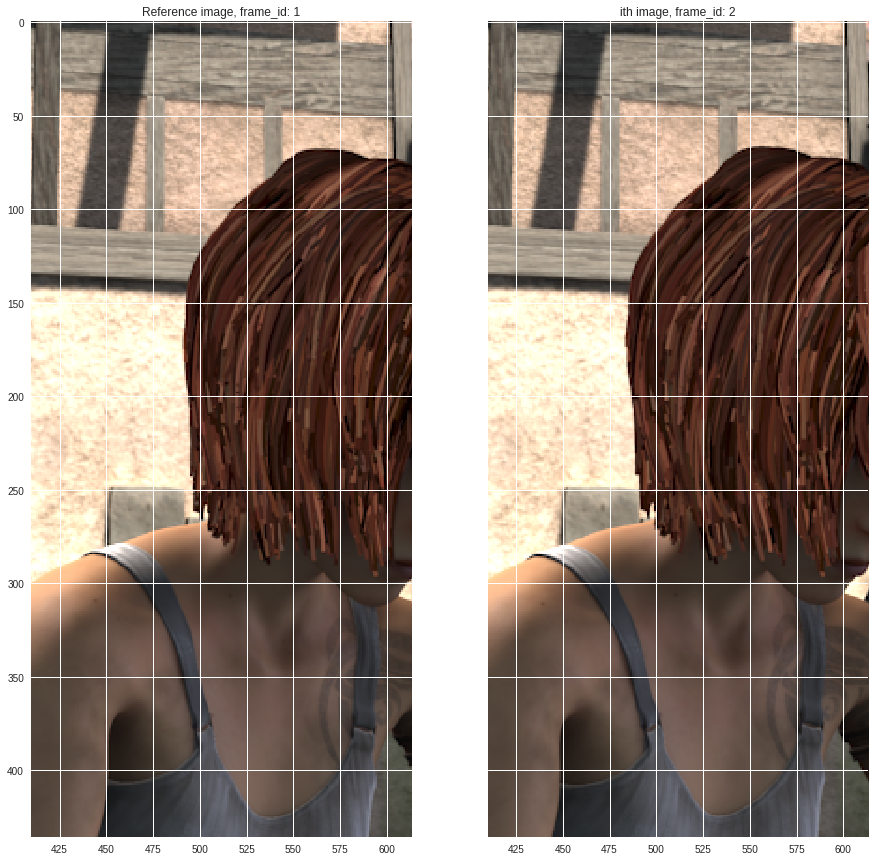

In [0]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(tgm.utils.tensor_to_image(img_ref)[:,:,::-1])
ax1.set_title('Reference image, frame_id: %d' %frame_ref_id)
ax2.imshow(tgm.utils.tensor_to_image(img_i)[:,:,::-1])
ax2.set_title('ith image, frame_id: %d' %frame_i_id)
plt.show()

In [0]:
class MyDepth(nn.Module):
    def __init__(self, height, width):
        super(MyDepth, self).__init__()
        self.depth = nn.Parameter(torch.Tensor(1, height, width))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self.depth)

    def forward(self):
        return torch.unsqueeze(self.depth, dim=0)  # 1xheightxwidth

class InvDepth(nn.Module):
    def __init__(self, height, width, min_depth=0.50, max_depth=25.):
        super(InvDepth, self).__init__()
        self._min_range = 1. / max_depth
        self._max_range = 1. / min_depth

        self.w = nn.Parameter(self._init_weights(height, width))

    def _init_weights(self, height, width):
        r1, r2 = self._min_range, self._min_range + (self._max_range -
                                                     self._min_range) * 0.1
        w_init = (r1 - r2) * torch.rand(1, 1, height, width) + r2
        return w_init

    def copy_(self, other):
        self.w.data.copy_(other.data)

    def forward(self):
        return self.w.clamp(min=self._min_range, max=self._max_range)

In [0]:
height, width = img_ref.shape[2], img_ref.shape[3]
inv_depth_ref = InvDepth(height, width).to(device)
optimizer = optim.Adam(inv_depth_ref.parameters(), lr=learning_rate)
#optimizer = optim.SGD(inv_depth_ref.parameters(), lr=learning_rate, momentum=0.9)
# send data to device
img_ref, img_i = img_ref.to(device), img_i.to(device)

In [0]:
warper = tgm.DepthWarper(cam_i)
warper.compute_homographies(cam_ref)



In [0]:
for iter_idx in range(num_iterations):

    # compute the inverse depth and warp the source image                                                                                
    img_i_to_ref = warper(inv_depth_ref(), img_i)

    # compute the photometric loss
    loss = F.l1_loss(img_i_to_ref, img_ref, reduction='none')

    # propagate the error just for a fixed window
    w_size = 100  # window size
    h_2, w_2 = height // 2, width // 2
    #loss = loss[..., h_2 - w_size:h_2 + w_size, w_2 - w_size:w_2 + w_size]
    loss = torch.mean(loss)

    # compute gradient and update optimizer parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_idx % log_interval == 0 or iter_idx == num_iterations-1:
        print('Train iteration: {}/{}\tLoss: {:.6}'.format(
        iter_idx, num_iterations, loss.item()))
        # merge warped and target image for visualization                                                                                
        img_i_to_ref = warper(inv_depth_ref(), img_i)
        
        img_vis = 0.5 * (img_i_to_ref + img_ref)
           
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        fig.set_figheight(15); fig.set_figwidth(15)
        ax1.imshow(clip_and_convert_tensor(img_vis))
        ax1.set_title('merge warped and ref image')
        
        ax3.imshow(clip_and_convert_tensor(img_i_to_ref))        
        ax3.set_title('warped image')
        est_depth_t = inv_depth_ref()
        est_depth_t = est_depth_t / (est_depth_t.max() + EPS)

        est_depth = tgm.utils.tensor_to_image(est_depth_t).squeeze()
        est_depth = np.clip(est_depth*255., 0, 255)
        est_depth = est_depth.astype('uint8')
        ax2.imshow(est_depth, cmap='gray')
        ax2.set_title('Depth')
        plt.show()

Train iteration: 0/50000	Loss: 0.0223605


ValueError: ignored

Train iteration: 1000/50000	Loss: 0.0195094


ValueError: ignored

Train iteration: 2000/50000	Loss: 0.0177594


ValueError: ignored

Train iteration: 3000/50000	Loss: 0.0166664


ValueError: ignored

Train iteration: 4000/50000	Loss: 0.0158575


ValueError: ignored

Train iteration: 5000/50000	Loss: 0.0152149


ValueError: ignored

Train iteration: 6000/50000	Loss: 0.0146803


ValueError: ignored

Train iteration: 7000/50000	Loss: 0.0142266


ValueError: ignored

Train iteration: 8000/50000	Loss: 0.0138473


ValueError: ignored

Train iteration: 9000/50000	Loss: 0.0135478


ValueError: ignored

Train iteration: 10000/50000	Loss: 0.0133021


ValueError: ignored

Train iteration: 11000/50000	Loss: 0.0130847


ValueError: ignored

Train iteration: 12000/50000	Loss: 0.0128876


ValueError: ignored

Train iteration: 13000/50000	Loss: 0.0127128


ValueError: ignored

Train iteration: 14000/50000	Loss: 0.0125595


ValueError: ignored

Train iteration: 15000/50000	Loss: 0.012426


ValueError: ignored

Train iteration: 16000/50000	Loss: 0.0123086


ValueError: ignored

Train iteration: 17000/50000	Loss: 0.0122031


ValueError: ignored

Train iteration: 18000/50000	Loss: 0.0121084


ValueError: ignored

Train iteration: 19000/50000	Loss: 0.0120264


ValueError: ignored

Train iteration: 20000/50000	Loss: 0.0119571


ValueError: ignored

Train iteration: 21000/50000	Loss: 0.0118992


ValueError: ignored

Train iteration: 22000/50000	Loss: 0.0118524


ValueError: ignored

Train iteration: 23000/50000	Loss: 0.0118155


ValueError: ignored

Train iteration: 24000/50000	Loss: 0.0117869


ValueError: ignored

Train iteration: 25000/50000	Loss: 0.0117639


ValueError: ignored

Train iteration: 26000/50000	Loss: 0.0117453


ValueError: ignored

Train iteration: 27000/50000	Loss: 0.0117299


ValueError: ignored

Train iteration: 28000/50000	Loss: 0.0117173


ValueError: ignored

Train iteration: 29000/50000	Loss: 0.011707


ValueError: ignored

Train iteration: 30000/50000	Loss: 0.0116986


ValueError: ignored

Train iteration: 31000/50000	Loss: 0.0116914


ValueError: ignored

Train iteration: 32000/50000	Loss: 0.0116851


ValueError: ignored

Train iteration: 33000/50000	Loss: 0.0116798


ValueError: ignored

Train iteration: 34000/50000	Loss: 0.0116751


ValueError: ignored

Train iteration: 35000/50000	Loss: 0.0116709


ValueError: ignored

Train iteration: 36000/50000	Loss: 0.0116669


ValueError: ignored

Train iteration: 37000/50000	Loss: 0.0116632


ValueError: ignored

Train iteration: 38000/50000	Loss: 0.0116598


ValueError: ignored

Train iteration: 39000/50000	Loss: 0.011657


ValueError: ignored

Train iteration: 40000/50000	Loss: 0.0116543


ValueError: ignored

Train iteration: 41000/50000	Loss: 0.0116519


ValueError: ignored

Train iteration: 42000/50000	Loss: 0.0116498


ValueError: ignored

Train iteration: 43000/50000	Loss: 0.0116476


ValueError: ignored

Train iteration: 44000/50000	Loss: 0.0116457


ValueError: ignored

Train iteration: 45000/50000	Loss: 0.0116439


ValueError: ignored

Train iteration: 46000/50000	Loss: 0.0116422


ValueError: ignored

Train iteration: 47000/50000	Loss: 0.0116407


ValueError: ignored

Train iteration: 48000/50000	Loss: 0.0116393


ValueError: ignored

Train iteration: 49000/50000	Loss: 0.0116379


ValueError: ignored

Train iteration: 49999/50000	Loss: 0.0116367


ValueError: ignored

In [0]:
# generate occlusion mask                                                                                                            
mask = ((img_ref - img_i_to_ref).mean(1) < 1e-1).float()

img_vis_warped = 0.5 * (img_i_to_ref + img_ref)
img_vis_warped_masked = mask * 0.5 * (img_i_to_ref + img_ref)

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(clip_and_convert_tensor(img_vis_warped))
ax1.set_title('Original warped image')
ax2.imshow(clip_and_convert_tensor(img_vis_warped_masked))
ax2.set_title('with occlusion mask')
plt.show()

In [0]:
# check CUDA version
!nvcc --version


## Create an animation with the figures

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


In [0]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
h = ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))


In [0]:
ani

#### another version


In [0]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [0]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)


In [0]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [0]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)


AttributeError: ignored

# Ipython tricks

follow the link https://www.dummies.com/programming/python/common-ipython-magic-functions/ 

In [0]:
%quickref
